In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

In [13]:
# ファイルパス
red_wine_path = './WineQuality-RedWine.csv'
white_wine_path = './WineQuality-WhiteWine.csv'

# データの読み込みと前処理
red_wine = pd.read_csv(red_wine_path)
white_wine = pd.read_csv(white_wine_path)

# 欠損値の処理
red_wine = red_wine.fillna(red_wine.mean())
white_wine = white_wine.fillna(white_wine.mean())

# 特徴量とターゲットの分離
X_red = red_wine.drop('quality', axis=1)
y_red = red_wine['quality']
X_white = white_wine.drop('quality', axis=1)
y_white = white_wine['quality']

# データの標準化
scaler = StandardScaler()
X_red_scaled = pd.DataFrame(scaler.fit_transform(X_red), columns=X_red.columns)
X_white_scaled = pd.DataFrame(scaler.fit_transform(X_white), columns=X_white.columns)

# データの分割
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red_scaled, y_red, test_size=0.2, random_state=42)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(X_white_scaled, y_white, test_size=0.2, random_state=42)

# 線形回帰モデルの学習
model_red = LinearRegression()
model_red.fit(X_train_red, y_train_red)

model_white = LinearRegression()
model_white.fit(X_train_white, y_train_white)

# 回帰係数の抽出
coefficients_red = pd.DataFrame(model_red.coef_, X_red.columns, columns=['Coefficient'])
coefficients_white = pd.DataFrame(model_white.coef_, X_white.columns, columns=['Coefficient'])

In [6]:
# 赤ワインモデルの予測と評価
y_pred_red = model_red.predict(X_test_red)
mse_red = mean_squared_error(y_test_red, y_pred_red)
rmse_red = root_mean_squared_error(y_test_red, y_pred_red)  
r2_red = r2_score(y_test_red, y_pred_red)

# 白ワインモデルの予測と評価
y_pred_white = model_white.predict(X_test_white)
mse_white = mean_squared_error(y_test_white, y_pred_white)
rmse_white = root_mean_squared_error(y_test_white, y_pred_white) 
r2_white = r2_score(y_test_white, y_pred_white)

# 結果の表示
print(f"赤ワインモデルのMSE: {mse_red:.4f}")
print(f"赤ワインモデルのRMSE: {rmse_red:.4f}")
print(f"赤ワインモデルのR^2: {r2_red:.4f}")

print(f"白ワインモデルのMSE: {mse_white:.4f}")
print(f"白ワインモデルのRMSE: {rmse_white:.4f}")
print(f"白ワインモデルのR^2: {r2_white:.4f}")

赤ワインモデルのMSE: 0.3900
赤ワインモデルのRMSE: 0.6245
赤ワインモデルのR^2: 0.4032
白ワインモデルのMSE: 0.5690
白ワインモデルのRMSE: 0.7543
白ワインモデルのR^2: 0.2653


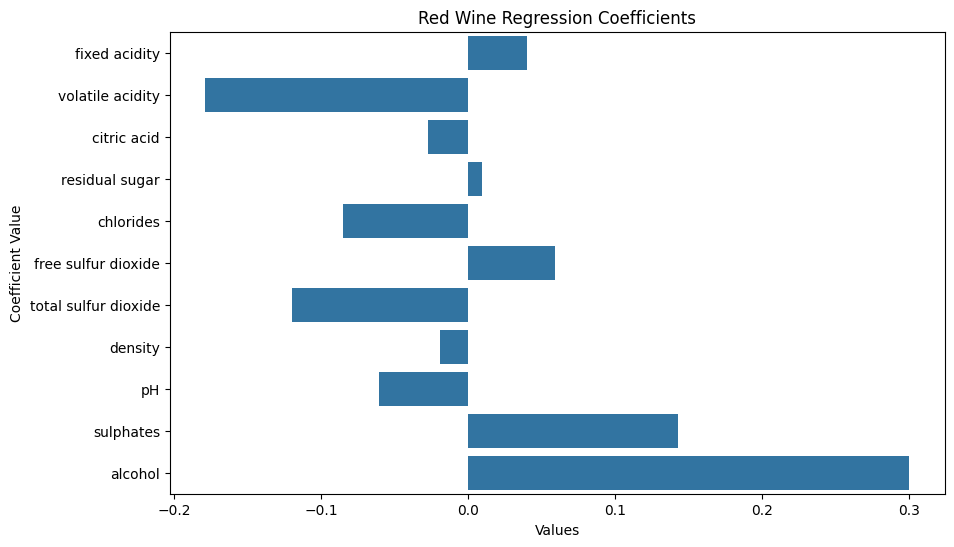

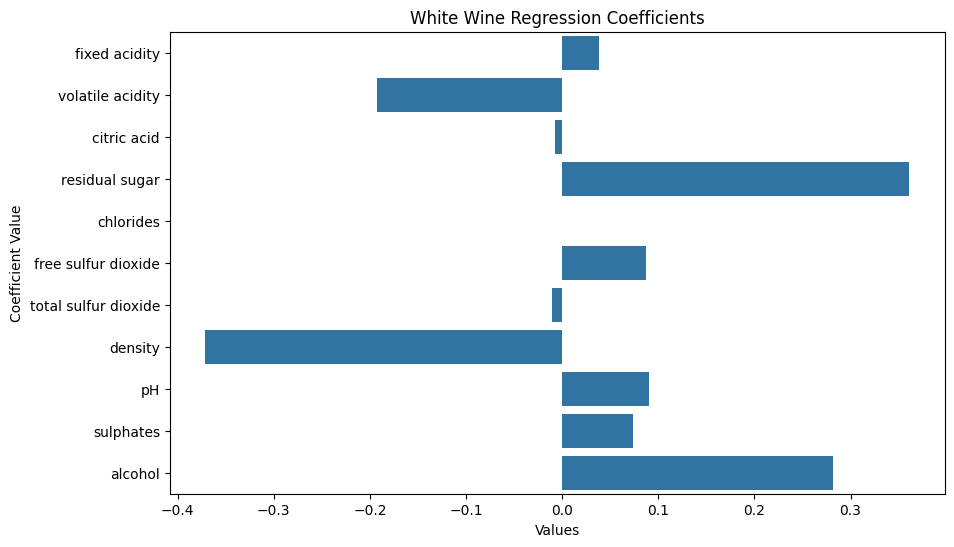

In [9]:
# グラフの作成と保存
def plot_coefficients(coefficients, title, filename):
    plt.figure(figsize=(10, 6))
    sns.barplot(y=coefficients.index, x='Coefficient', data=coefficients)
    plt.title(title)
    plt.xlabel('Values')
    plt.ylabel('Coefficient Value')
    plt.xticks(rotation=0)
    plt.savefig(filename)
    plt.show()

# 赤ワインの回帰係数のグラフ
plot_coefficients(coefficients_red, 'Red Wine Regression Coefficients', './result/red_wine_regression_coefficients.png')

# 白ワインの回帰係数のグラフ
plot_coefficients(coefficients_white, 'White Wine Regression Coefficients', './result/white_wine_regression_coefficients.png')


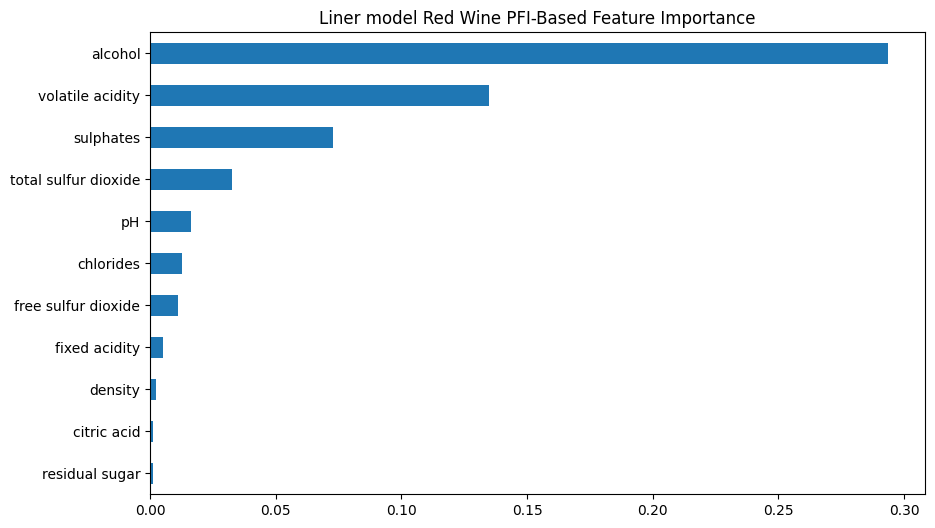

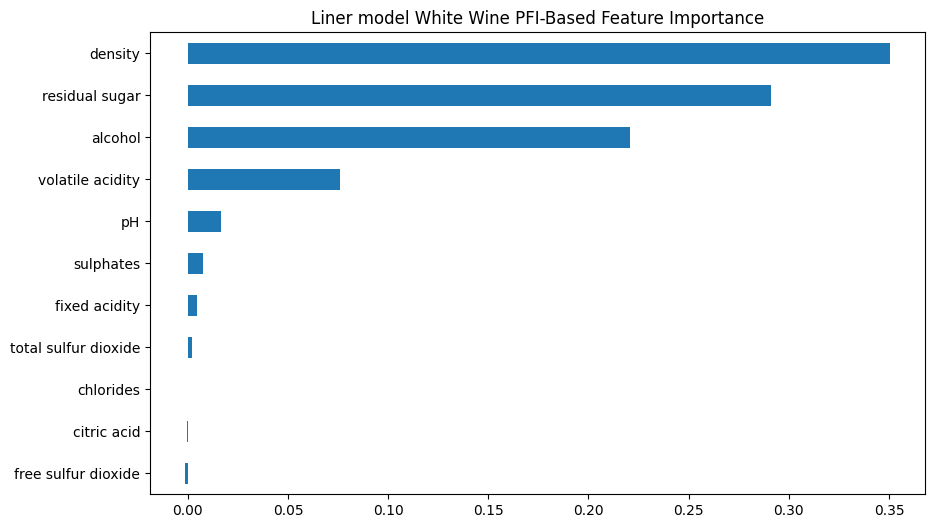

In [22]:
# PFIの計算とプロット
def plot_pfi(model, X_test, y_test, feature_names, title, save_path):
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importances = pd.Series(result.importances_mean, index=feature_names)
    importances.sort_values().plot(kind='barh', figsize=(10, 6))
    plt.title(title)
    plt.savefig(save_path)
    plt.show()

plot_pfi(model_red, X_test_red, y_test_red, X_red.columns, 'Liner model Red Wine PFI-Based Feature Importance', './result/LRM_PFI_red_wine_feature_importance.png')
plot_pfi(model_white, X_test_white, y_test_white, X_white.columns, 'Liner model White Wine PFI-Based Feature Importance', './result/LRM_PFI_white_wine_feature_importance.png')

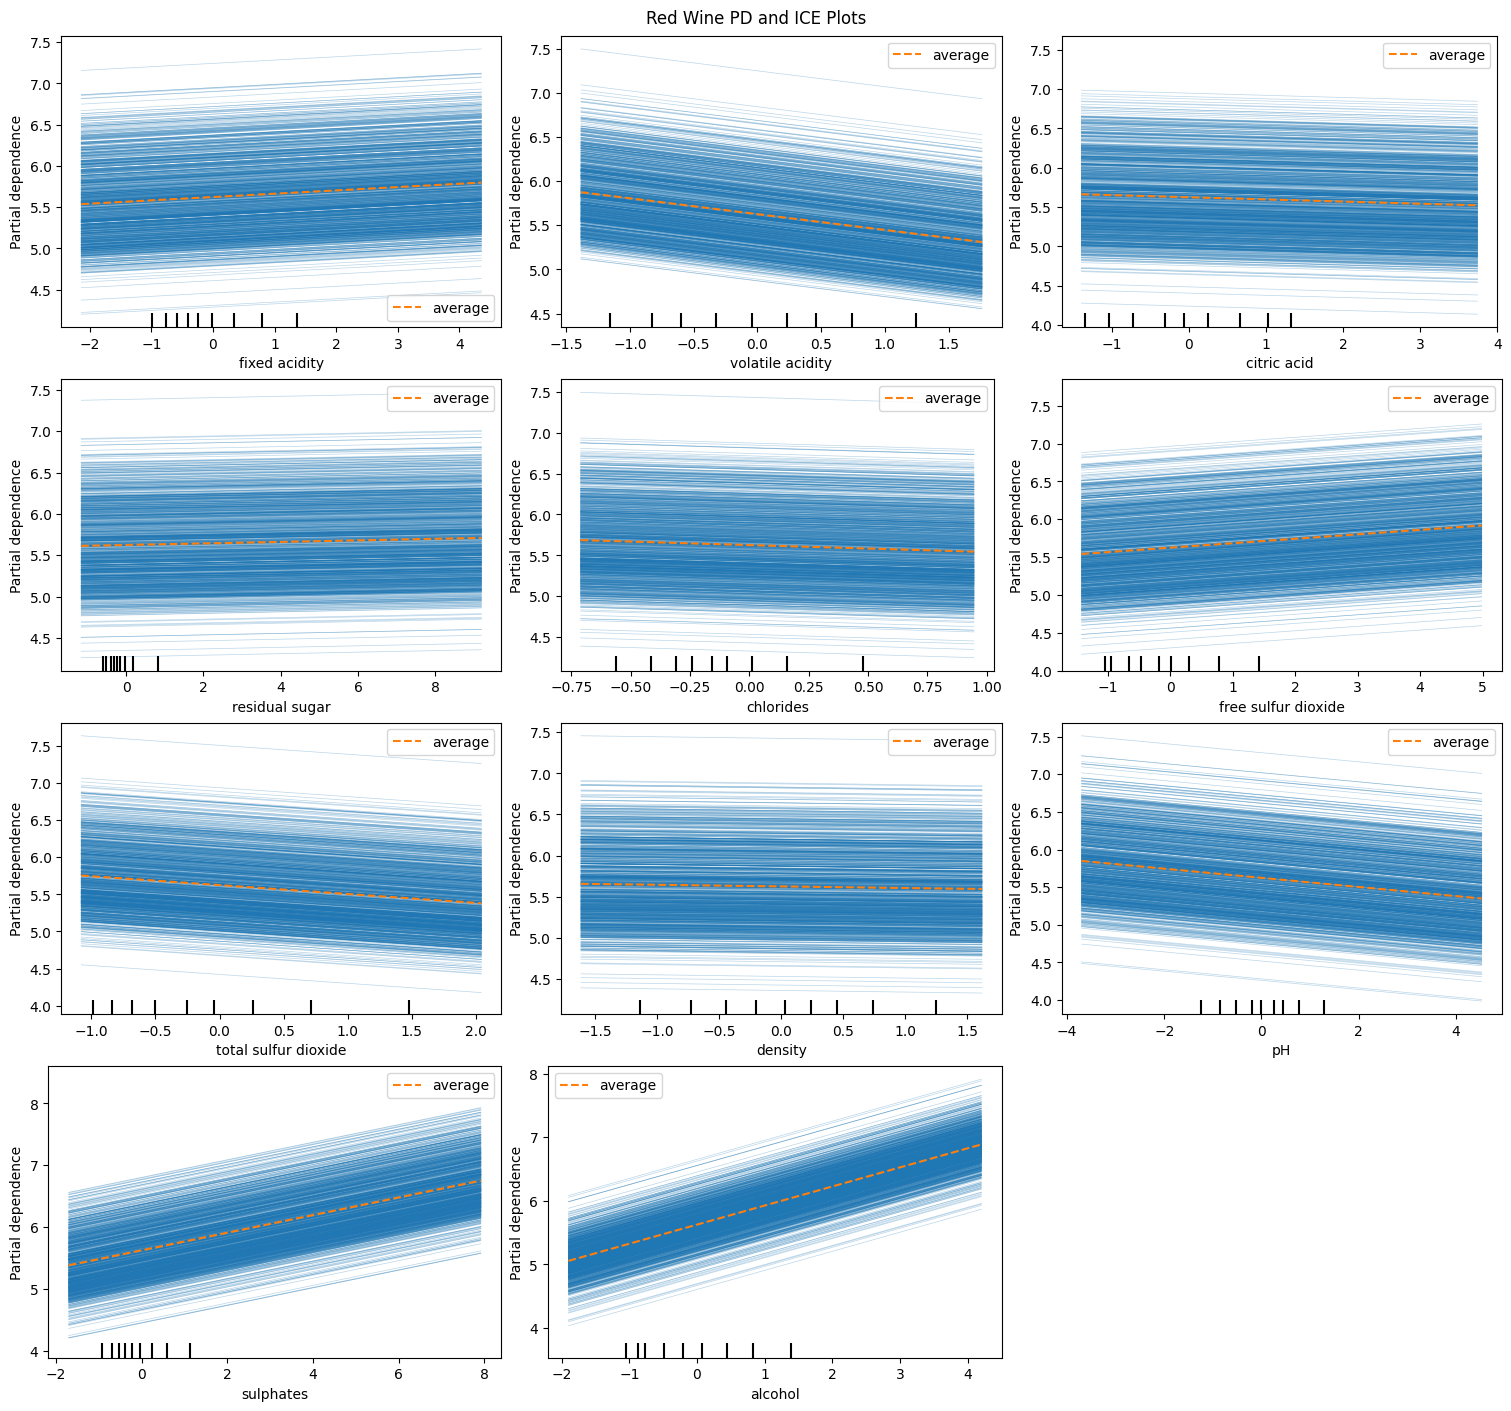

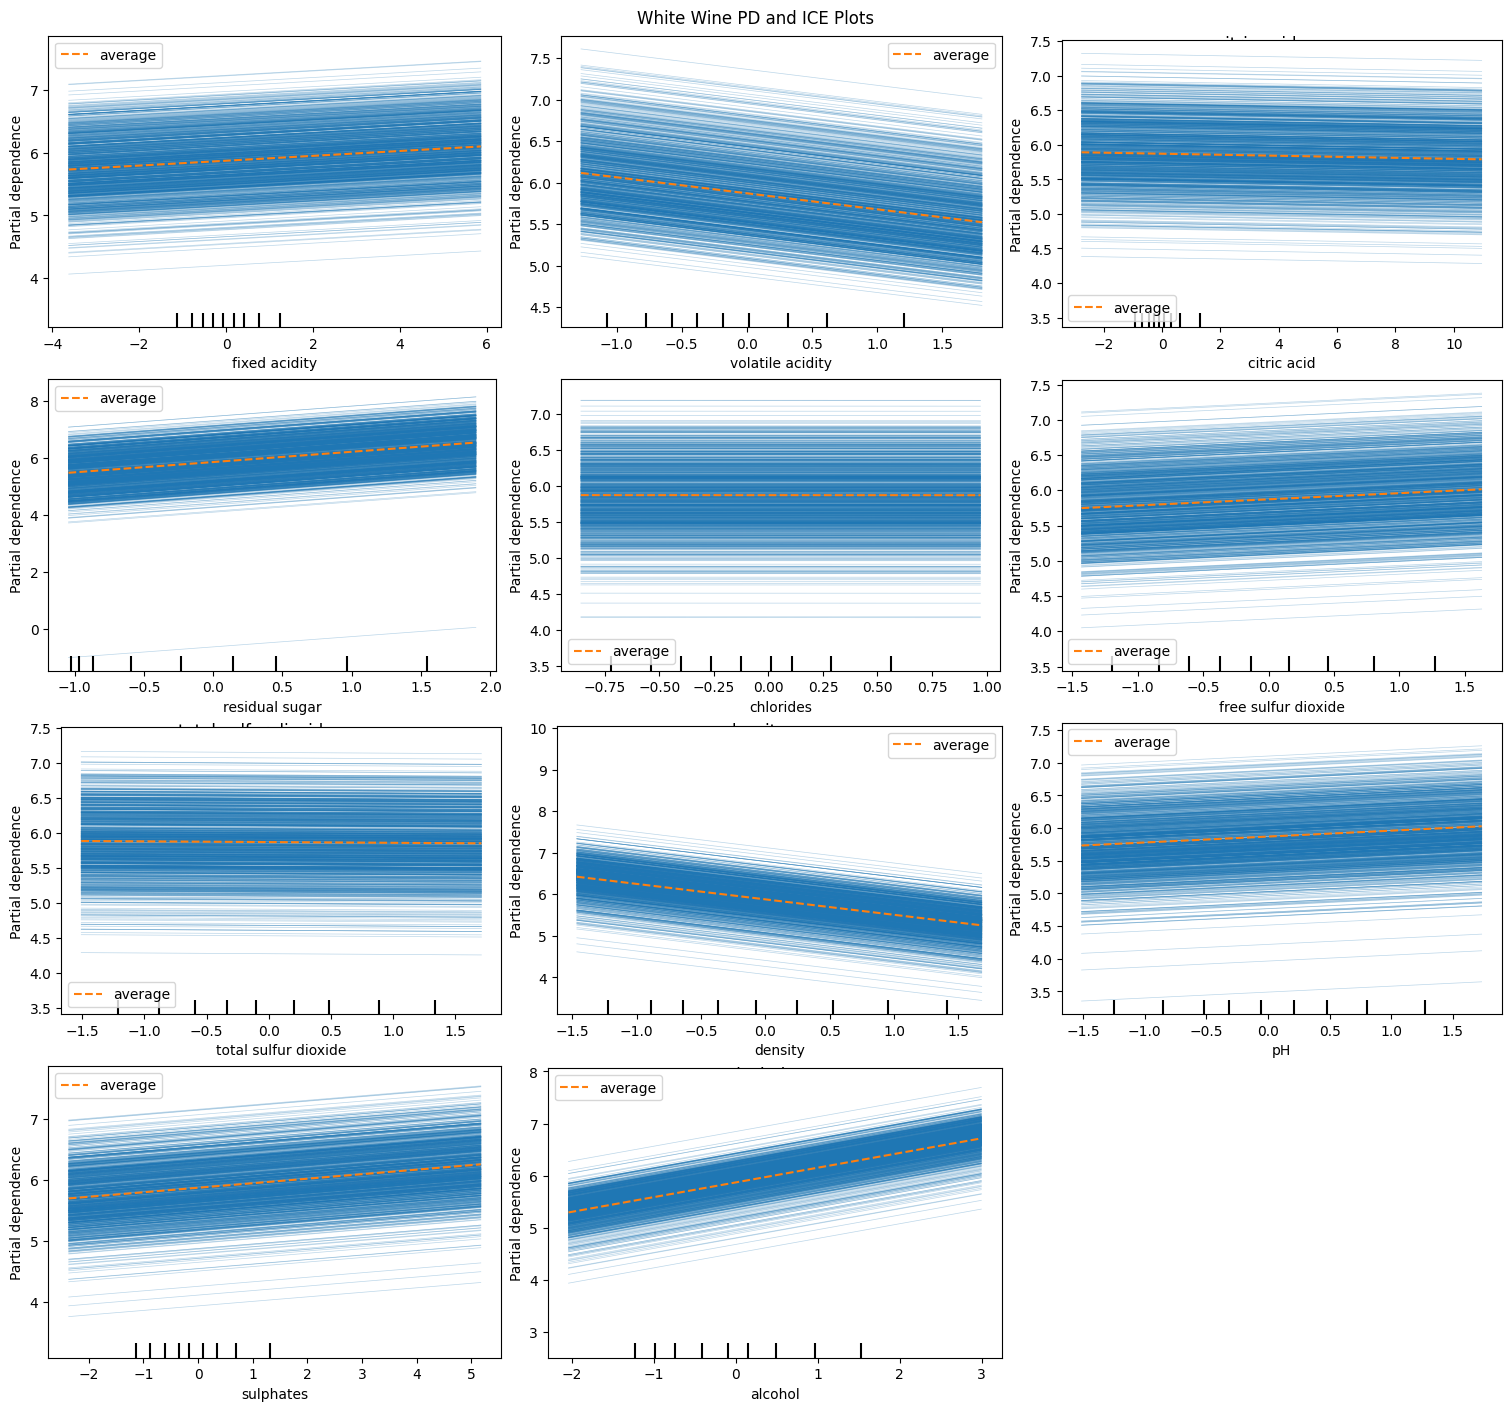

In [21]:
def plot_pd_ice(model, X_train, features, title, file_path, n_cols=3):
    n_rows = (len(features) + n_cols - 1) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows), constrained_layout=True)
    
    # 各特徴量に対するPDとICEプロットを生成
    for i, feature in enumerate(features):
        ax = axs[i // n_cols, i % n_cols]
        display = PartialDependenceDisplay.from_estimator(
            model,
            X_train,
            features=[feature],
            kind="both",  # PDとICEの両方を表示
            ax=ax
        )
        ax.set_title(feature)
    
    # 空のグラフを隠す
    for j in range(len(features), n_rows * n_cols):
        axs[j // n_cols, j % n_cols].axis('off')
    
    # タイトルと表示
    plt.suptitle(title)
    plt.savefig(file_path)
    plt.show()

# 赤ワインのデータに対してPDとICEプロットを生成
plot_pd_ice(model_red, pd.DataFrame(X_train_red, columns=X_red.columns), X_red.columns, 'Red Wine PD and ICE Plots', './result/LRM_red_wine_pd_ice_plots.png')

# 白ワインのデータに対してPDとICEプロットを生成
plot_pd_ice(model_white, pd.DataFrame(X_train_white, columns=X_white.columns), X_white.columns, 'White Wine PD and ICE Plots', './result/LRM_white_wine_pd_ice_plots.png')
